In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


#Loading data
ticker = ['AAPL']
data = yf.download(ticker, start='2015-01-01', end='2025-04-24')

In [ ]:
data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


In [ ]:
data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


In [ ]:
data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  0 non-null      float64
 1   (Close, AAPL)      0 non-null      float64
 2   (High, AAPL)       0 non-null      float64
 3   (Low, AAPL)        0 non-null      float64
 4   (Open, AAPL)       0 non-null      float64
 5   (Volume, AAPL)     0 non-null      float64
dtypes: float64(6)
memory usage: 0.0 bytes


In [ ]:
data.reset_index(inplace=True)

In [ ]:
data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL


In [ ]:
#handling missing values
data.isnull().sum()  #counts missing values in each columns

,,0
Price,Ticker,
Date,,0
Adj Close,AAPL,0
Close,AAPL,0
High,AAPL,0
Low,AAPL,0
Open,AAPL,0
Volume,AAPL,0


In [ ]:
data.dropna()      #remove rows with missing values

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL


In [ ]:
#removing duplicates
data.duplicated()          #checks for duplicates rows
data.drop_duplicates()     #remove duplicate rows

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL


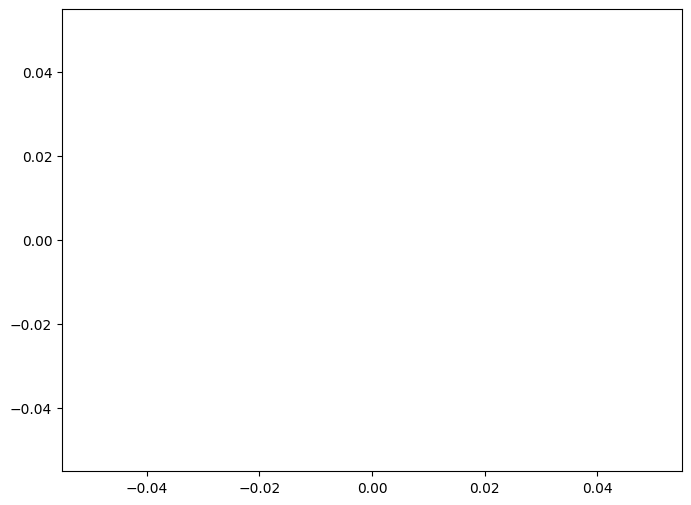

In [ ]:
ma_100_days = data.Close.rolling(100).mean()
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close,'g')
plt.show()

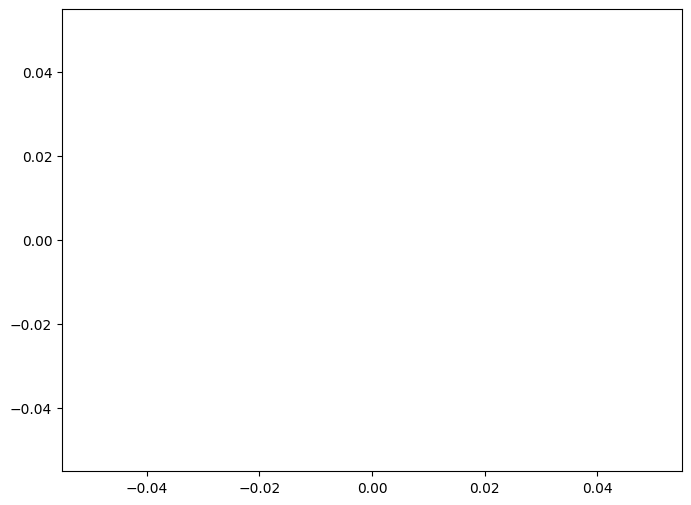

In [ ]:
ma_200_days = data.Close.rolling(200).mean()
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.Close,'g')
plt.show()

In [ ]:
# 2. Create shifted data for supervised learning
data = data[['Close']]
data.dropna(inplace=True)


data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Linear Regression
X_lr = np.array(data[['Close']])
y_lr = np.array(data['Target'])

# Train/Test split
split = int(len(data) * 0.8)
X_train_lr, X_test_lr = X_lr[:split], X_lr[split:]
y_train_lr, y_test_lr = y_lr[:split], y_lr[split:]

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)
lr_pred = lr_model.predict(X_test_lr)

# Predict next day price
latest_price = np.array([data['Close'].iloc[-1]]) #remove extra brackets
lr_next_day_price = lr_model.predict(latest_price.reshape(-1, 1))[0] #added reshape to fix input shape


# Accuracy for Linear Regression
lr_mape = mean_absolute_percentage_error(y_test_lr, lr_pred) * 100
lr_accuracy = 100 - lr_mape

print(f"📈 Linear Regression Prediction for Next Day: ${lr_next_day_price:.2f}")
print(f"✅ Linear Regression Accuracy: {lr_accuracy:.2f}%")

# ---------------------------- LSTM ----------------------------
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(data['Close']).reshape(-1, 1))

# Create sequences
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X_lstm, y_lstm = create_dataset(scaled_data)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Train/Test split
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train LSTM
lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=10, batch_size=64, verbose=0)

# Predict
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1))
y_test_lstm_orig = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Predict next day price
last_60_days = scaled_data[-60:].reshape(1, 60, 1)
lstm_next_day_scaled = lstm_model.predict(last_60_days)
lstm_next_day_price = scaler.inverse_transform(lstm_next_day_scaled)[0][0]

# Accuracy for LSTM
lstm_mape = mean_absolute_percentage_error(y_test_lstm_orig, lstm_pred) * 100
lstm_accuracy = 100 - lstm_mape

print(f"📊 LSTM Prediction for Next Day: ${lstm_next_day_price:.2f}")
print(f"✅ LSTM Accuracy: {lstm_accuracy:.2f}%")


<ipython-input-27-55e6460c0945>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
# Plotting Linear Regression Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_lr, label='Actual Price')
plt.plot(lr_pred, label='Predicted Price')
plt.title('Linear Regression: Actual vs Predicted Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plotting LSTM Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_lstm_orig, label='Actual Price')
plt.plot(lstm_pred, label='Predicted Price')
plt.title('LSTM: Actual vs Predicted Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
history = lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm),
                         epochs=10, batch_size=64, verbose=1)


In [ ]:
# Plotting Training vs Validation Loss(Loss Curve)
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Heatmap of Actual vs Predicted Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure all arrays are the same length by trimming to the shortest one
min_len = min(len(y_test_lr), len(lr_pred), len(y_test_lstm_orig), len(lstm_pred))

# Slice arrays to the minimum length
y_test_lr = y_test_lr[:min_len]
lr_pred = lr_pred[:min_len]
y_test_lstm_orig = y_test_lstm_orig[:min_len].flatten()  # Flatten if necessary
lstm_pred = lstm_pred[:min_len].flatten()  # Flatten if necessary


# Combine actual vs predicted in a DataFrame
comparison_df = pd.DataFrame({
    'Actual_LR': y_test_lr,
    'Predicted_LR': lr_pred,
    'Actual_LSTM': y_test_lstm_orig,
    'Predicted_LSTM': lstm_pred
})

# Compute correlation matrix
correlation = comparison_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📊 Correlation Heatmap: Actual vs Predicted")
plt.show()

In [ ]:
#next day forecast highlighted on a chart
# Combined last 100 actuals and predicted next day
last_100_actual = data['Close'].values[-100:]
x_range = list(range(len(last_100_actual) + 1))  # 100 + 1 = 101 points

# Ensure next day price is a scalar
if isinstance(lr_next_day_price, np.ndarray):
    next_day_price = lr_next_day_price.flatten()[0]
else:
    next_day_price = lr_next_day_price

# Create forecast array
forecast = np.append(last_100_actual, next_day_price)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_range[:-1], last_100_actual, label='Historical Price')
plt.plot(x_range, forecast, '--', label='Next Day Forecast', color='orange', marker='o')
plt.axvline(x=len(last_100_actual)-1, color='gray', linestyle='--')
plt.title('Next Day Forecast Highlighted')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#creating model comparision table
# Linear Regression Metrics
lr_residuals = y_test_lr - lr_pred
lr_std_dev = np.std(lr_residuals)

lr_rmse = np.sqrt(mean_squared_error(y_test_lr, lr_pred))
lr_mae = mean_absolute_error(y_test_lr, lr_pred)
lr_r2 = r2_score(y_test_lr, lr_pred)

# 95% confidence interval (roughly ±1.96 * std dev)
lr_lower_bound = lr_next_day_price - 1.96 * lr_std_dev
lr_upper_bound = lr_next_day_price + 1.96 * lr_std_dev


In [ ]:
# LSTM Metrics
lstm_residuals = y_test_lstm_orig.flatten() - lstm_pred.flatten()
lstm_std_dev = np.std(lstm_residuals)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_orig, lstm_pred))
lstm_mae = mean_absolute_error(y_test_lstm_orig, lstm_pred)
lstm_r2 = r2_score(y_test_lstm_orig, lstm_pred) # This line is added to calculate and assign lstm_r2

lstm_lower_bound = lstm_next_day_price - 1.96 * lstm_std_dev
lstm_upper_bound = lstm_next_day_price + 1.96 * lstm_std_dev



In [ ]:
# Create a dictionary with full model performance
comparison_data = {
    'Model': ['Linear Regression', 'LSTM'],
    'Accuracy (%)': [lr_accuracy, lstm_accuracy],
    'RMSE': [lr_rmse, lstm_rmse],
    'MAE': [lr_mae, lstm_mae],
    'R² Score': [lr_r2, lstm_r2],
    'Next Day Predicted Price ($)': [lr_next_day_price, lstm_next_day_price],
      'Prediction Interval ($)': [
        f"{lr_lower_bound:.2f} to {lr_upper_bound:.2f}",
        f"{lstm_lower_bound:.2f} to {lstm_upper_bound:.2f}"]
}

# Convert into a DataFrame
comparison_table = pd.DataFrame(comparison_data)
comparison_table = comparison_table.round(2)

# Print the detailed table
print("\n📋 Detailed Model Comparison Table:")
print(comparison_table.to_string(index=False))



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example: Plot LSTM last few test predictions with intervals
days = np.arange(len(y_test_lstm_orig))

plt.figure(figsize=(12, 6))
plt.plot(days, y_test_lstm_orig, label='Actual')
plt.plot(days, lstm_pred, label='Predicted')

# Calculate standard deviation of residuals for LSTM
lstm_residuals = y_test_lstm_orig.flatten() - lstm_pred.flatten()
lstm_std = np.std(lstm_residuals)

# Confidence level
confidence_level = 1.96  # For 95% prediction interval

# Plot upper and lower bounds
plt.fill_between(days,
                 lstm_pred.flatten() - (confidence_level * lstm_std),
                 lstm_pred.flatten() + (confidence_level * lstm_std),
                 color='gray', alpha=0.3, label='Prediction Interval (95%)')

plt.title('LSTM Prediction with 95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [ ]:
# --------------------- Random Forest ---------------------
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_lr, y_train_lr)  # same features as linear regression

# Predict
rf_pred = rf_model.predict(X_test_lr)
min_len = min(len(y_test_lr), len(rf_pred))
y_test_lr = y_test_lr[:min_len]
rf_pred = rf_pred[:min_len]

# Predict next day
rf_next_day_price = rf_model.predict(latest_price)[0]

# Metrics
rf_mape = mean_absolute_percentage_error(y_test_lr, rf_pred) * 100
rf_accuracy = 100 - rf_mape
rf_rmse = np.sqrt(mean_squared_error(y_test_lr, rf_pred))
rf_mae = mean_absolute_error(y_test_lr, rf_pred)
rf_r2 = r2_score(y_test_lr, rf_pred)

# Residuals and Prediction Interval
rf_residuals = y_test_lr - rf_pred
rf_std = np.std(rf_residuals)
rf_lower_bound = rf_next_day_price - (confidence_level * rf_std)
rf_upper_bound = rf_next_day_price + (confidence_level * rf_std)


# --------------------- XGBoost ---------------------
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_lr, y_train_lr)

# Predict
xgb_pred = xgb_model.predict(X_test_lr)

min_len = min(len(y_test_lr), len(xgb_pred))
y_test_lr_xgb = y_test_lr[:min_len]  # Create a subset of y_test_lr for XGBoost
xgb_pred = xgb_pred[:min_len]
# Predict next day
xgb_next_day_price = xgb_model.predict(latest_price)[0]

# Metrics
xgb_mape = mean_absolute_percentage_error(y_test_lr, xgb_pred) * 100
xgb_accuracy = 100 - xgb_mape
xgb_rmse = np.sqrt(mean_squared_error(y_test_lr, xgb_pred))
xgb_mae = mean_absolute_error(y_test_lr, xgb_pred)
xgb_r2 = r2_score(y_test_lr, xgb_pred)

# Residuals and Prediction Interval
xgb_residuals = y_test_lr - xgb_pred
xgb_std = np.std(xgb_residuals)
xgb_lower_bound = xgb_next_day_price - (confidence_level * xgb_std)
xgb_upper_bound = xgb_next_day_price + (confidence_level * xgb_std)


In [ ]:
# ----------------- Updated Model Comparison Table -----------------

comparison_data = {
    'Model': ['Linear Regression', 'LSTM', 'Random Forest', 'XGBoost'],
    'Accuracy (%)': [lr_accuracy, lstm_accuracy, rf_accuracy, xgb_accuracy],
    'RMSE': [lr_rmse, lstm_rmse, rf_rmse, xgb_rmse],
    'MAE': [lr_mae, lstm_mae, rf_mae, xgb_mae],
    'R² Score': [lr_r2, lstm_r2, rf_r2, xgb_r2],
    'Next Day Predicted Price ($)': [lr_next_day_price, lstm_next_day_price, rf_next_day_price, xgb_next_day_price],
    'Prediction Interval ($)': [
        f"{lr_lower_bound:.2f} to {lr_upper_bound:.2f}",
        f"{lstm_lower_bound:.2f} to {lstm_upper_bound:.2f}",
        f"{rf_lower_bound:.2f} to {rf_upper_bound:.2f}",
        f"{xgb_lower_bound:.2f} to {xgb_upper_bound:.2f}"
    ]
}

# Convert into a DataFrame
comparison_table = pd.DataFrame(comparison_data)
comparison_table = comparison_table.round(2)

# Print the detailed table
from tabulate import tabulate

print("\n📋 Detailed Model Comparison Table:")
print(tabulate(comparison_table, headers='keys', tablefmt='fancy_grid', showindex=False))


In [ ]:
import seaborn as sns

# Bar chart for Model Accuracies with updated hue
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy (%)', data=comparison_table, palette='viridis', hue='Model', legend=False)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)  # Set y-axis from 0 to 100
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
